# Time to review in Open Stack Gerrit 

In [336]:
import MySQLdb
import pandas

def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "lp_vs_gerrit_metrics"
   port=3306
   use_unicode=True

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db, port = port, use_unicode = use_unicode)
      return db, db.cursor()
   except:
      logging.error("Database connection error!")
      raise
        
def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    
db, cursor = connect()

### The next query focuses on collecting data for measuring the time to review the issues in Gerrit. 
For this we extract the issues that have been closed. 

In [ ]:
cursor.execute(""" create table review_time as 
            select i.issue                       as gerrit_issue,  
                   t0.opening_date               as gerrit_opening_date,  
                   t1.closing_date               as gerrit_closing_date, 
                   timestampdiff(SECOND, t0.opening_date, t1.closing_date) as time2close, 
                   t.url                         as gerrit_tracker,
                   i.status                      as current_status 
            from issuesCR i, 
                 trackers t, 
                 changes ch, 
                 (select i.id as issue_id, 
                         ch.changed_on as closing_date 
                  from issuesCR i 
                    left join changes ch 
                    on ch.issue_id = i.id and 
                       field='status' and 
                       new_value='MERGED' ) t1, 
                 (select ch.issue_id, 
                         ch.changed_on as opening_date 
                  from changes ch 
                  where ch.field='status' and 
                        ch.new_value='UPLOADED' and 
                        ch.old_value=1) t0 
            where i.tracker_id=t.id and 
                  ch.issue_id = i.id and 
                  i.id=t0.issue_id  and 
                  i.id=t1.issue_id 
            group by i.issue """)

## Time to review in Openstack Gerrit from year 2011 to 2015

In [338]:
query = " select * from review_time where current_status='MERGED' "

In [339]:
data = execute_query(cursor, query)

In [340]:
data_list = list(data)

In [341]:
pandas_ds = pandas.DataFrame(data_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
pandas_ds.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [277]:
# pandas_ds

166727 total fixes merged in OpenStack from 2011 to 2015.

In [342]:
# time to review in Open Stack form 2011 to 2015 
print "Median time for reviewing in Gerrit form 2011 to 2015: %f hours" % (pandas_ds.median()/3600.0)
print "Quantiles: (time measured in seconds) "
print pandas_ds.quantile([0.25, 0.5, 0.75])

Median time for reviewing in Gerrit form 2011 to 2015: 52.171111 hours
Quantiles: (time measured in seconds) 
      time2close
0.25    29587.25
0.50   187816.00
0.75   769489.50


Populating the interactive namespace from numpy and matplotlib


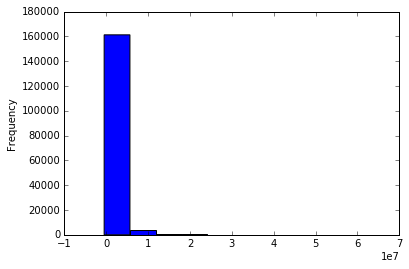

In [38]:
# Histogram of the time for solving an issue: x-axis the time and y-axis the fixes merged
%pylab inline
pandas_ds["time2close"].plot(kind="hist")

## Time to review in Open Stack during 2015

In [311]:
# review time in OS for year 2015
os_review_time_2015 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2015-01-01') & (pandas_ds["gerrit_closing_date"] <= '2016-01-01')];
# os_review_time_2015

74651 fixes merged in OS during 2015.

In [312]:
# Median time and quantiles for OS 2015
print "Median Time for reviewing during 2015: %f hours" % (os_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print os_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 57.915833 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     36779.0
0.50    208497.0
0.75    829968.5


## Time to review in Open Stack during 2014

In [314]:
# review time in OS for year 2014
os_review_time_2014 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2014-01-01') & (pandas_ds["gerrit_closing_date"] <= '2015-01-01')];
# os_review_time_2014

49482 fixes merged in OS during 2014.

In [316]:
# Median time and quantiles for OS 2014
print "Median Time for reviewing during 2015: %f hours" % (os_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print os_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 78.158472 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     50385.0
0.50    281370.5
0.75   1084131.0


## Time to review in Open Stack during 2013

In [318]:
# review time in OS for year 2013
os_review_time_2013 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2013-01-01') & (pandas_ds["gerrit_closing_date"] <= '2014-01-01')];
# os_review_time_2013

28236 fixes merged in OS during 2013.

In [319]:
# Median time and quantiles for OS 2013
print "Median Time for reviewing during 2013: %f hours" % (os_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print os_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 36.641667 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     17918.5
0.50    131910.0
0.75    554299.5


## Time to review in Open Stack during 2012

In [322]:
# review time in OS for year 2012
os_review_time_2012 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2012-01-01') & (pandas_ds["gerrit_closing_date"] <= '2013-01-01')];
# os_review_time_2012

11084 fixes merged in OS during 2012.

In [323]:
# Median time and quantiles for OS 2012
print "Median Time for reviewing during 2012: %f hours" % (os_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print os_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 16.795833 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     3131.25
0.50    60465.00
0.75   294363.75


## Time to review in Open Stack during 2011

In [326]:
# review time in OS for year 2011
os_review_time_2011 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2011-01-01') & (pandas_ds["gerrit_closing_date"] <= '2012-01-01')];
# os_review_time_2011

1610 fixes merged in OS during 2011.

In [327]:
# Median time and quantiles for OS 2011
print "Median Time for reviewing during 2011: %f hours" % (os_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print os_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 3.630417 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       44.25
0.50    13069.50
0.75   154186.00


# Time to review in Nova

In [4]:
query_nova = """ select * from review_time 
where 
gerrit_tracker like '%nova%' and 
current_status = 'MERGED' """

In [5]:
data_nova = execute_query(cursor,query_nova)

In [6]:
data_nova_list = list(data_nova)

In [7]:
data_nova_df = pandas.DataFrame(data_nova_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_nova_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

### 16191 fixes have been merged in Nova project from 2011 to 2015 and January 2016.

In [30]:
# Median time and quantiles in Nova from 2011 to 2015
print "Median Time for reviewing in Nova from 2011 to 2015: %f hours" % (data_nova_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_nova_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Nova from 2011 to 2015: 125.098333 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     79349.5
0.50    450354.0
0.75   1655789.0


## Year 2015

In [17]:
# review time in Nova for year 2015
nova_review_time_2015 = data_nova_df[(data_nova_df["gerrit_closing_date"] >= '2015-01-01') & (data_nova_df["gerrit_closing_date"] <= '2016-01-01')];
# nova_review_time_2015

3790 fixes were merged in Nova during 2015

In [18]:
# Median time and quantiles for Nova 2015
print "Median Time for reviewing during 2015: %f hours" % (nova_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print nova_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for closing a ticket: 265.731667 hours
Quantiles: (time reported in seconds) 
      time2close
0.25   213534.50
0.50   956634.00
0.75  3337771.75


## Year 2014

In [21]:
# review time in Nova for year 2014
nova_review_time_2014 = data_nova_df[(data_nova_df["gerrit_closing_date"] >= '2014-01-01') & (data_nova_df["gerrit_closing_date"] <= '2015-01-01')];
#nova_review_time_2014

4143 fixes have been merged in Nova during 2014

In [22]:
# Median time and quantiles for Nova 2014
print "Median Time for reviewing during 2014: %f hours" % (nova_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print nova_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for closing a ticket: 264.238056 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    244560.0
0.50    951257.0
0.75   2955962.5


## Year 2013

In [25]:
# review time in Nova for year 2013
nova_review_time_2013 = data_nova_df[(data_nova_df["gerrit_closing_date"] >= '2013-01-01') & (data_nova_df["gerrit_closing_date"] <= '2014-01-01')];
#nova_review_time_2013

4155 fixes have been merged in Nova during 2013

In [26]:
# Median time and quantiles for Nova 2013
print "Median Time for reviewing during 2013: %f hours" % (nova_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print nova_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 131.866111 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     93782.5
0.50    474718.0
0.75   1269235.0


## Year 2012

In [28]:
# review time in Nova for year 2012
nova_review_time_2012 = data_nova_df[(data_nova_df["gerrit_closing_date"] >= '2012-01-01') & (data_nova_df["gerrit_closing_date"] <= '2013-01-01')];
#nova_review_time_2012

3454 fixes were merged in Nova during 2012

In [29]:
# Median time and quantiles for Nova 2012
print "Median Time for reviewing during 2012: %f hours" % (nova_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print nova_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 24.404167 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     9062.25
0.50    87855.00
0.75   356493.00


## Year 2011

In [132]:
# review time in Nova for year 2011
nova_review_time_2011 = data_nova_df[(data_nova_df["gerrit_closing_date"] >= '2011-01-01') & (data_nova_df["gerrit_closing_date"] <= '2012-01-01')];
# nova_review_time_2011

545 fixes merged in Nova during 2011

In [133]:
# Median time and quantiles for Nova 2011
print "Median Time for reviewing during 2011: %f hours" % (nova_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print nova_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 21.650833 hours
Quantiles: (time reported in seconds) 
      time2close
0.25        5992
0.50       77943
0.75      321790


# Time to review in Swift

In [39]:
query_swift = """ select * from review_time 
where 
gerrit_tracker like '%swift%' and 
current_status = 'MERGED' """

In [40]:
data_swift = execute_query(cursor,query_swift)

In [41]:
data_swift_list = list(data_swift)

In [42]:
data_swift_df = pandas.DataFrame(data_swift_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_swift_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [44]:
# data_swift_df

### 2972 fixes have been merged in Swift project from 2011 to 2015 and January 2016.

In [126]:
# Median time and quantiles in Swift from 2011 to 2015
print "Median Time for reviewing in Swift from 2011 to 2015: %f hours" % (data_swift_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_swift_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Swift from 2011 to 2015: 67.676667 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    31659.75
0.50   243636.00
0.75   991619.50


## Year 2015

In [47]:
# review time in Swift for year 2015
swift_review_time_2015 = data_swift_df[(data_swift_df["gerrit_closing_date"] >= '2015-01-01') & (data_swift_df["gerrit_closing_date"] <= '2016-01-01')];
#swift_review_time_2015

921 fixes were merged in Swift during 2015

In [48]:
# Median time and quantiles for Swift 2015
print "Median Time for reviewing during 2015: %f hours" % (swift_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print swift_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 99.542500 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       54818
0.50      358353
0.75     1662459


## Year 2014

In [50]:
# review time in Swift for year 2014
swift_review_time_2014 = data_swift_df[(data_swift_df["gerrit_closing_date"] >= '2014-01-01') & (data_swift_df["gerrit_closing_date"] <= '2015-01-01')];
#swift_review_time_2014

760 fixes have been merged in Swift during 2014

In [51]:
# Median time and quantiles for Swift 2014
print "Median Time for reviewing during 2014: %f hours" % (swift_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print swift_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 77.794444 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    46326.25
0.50   280060.00
0.75  1180614.00


## Year 2013

In [53]:
# review time in Swift for year 2013
swift_review_time_2013 = data_swift_df[(data_swift_df["gerrit_closing_date"] >= '2013-01-01') & (data_swift_df["gerrit_closing_date"] <= '2014-01-01')];
#swift_review_time_2013

780 fixes have been merged in Swift during 2013

In [54]:
# Median time and quantiles for Swift 2013
print "Median Time for reviewing during 2013: %f hours" % (swift_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print swift_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 60.196667 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     27134.5
0.50    216708.0
0.75    790217.0


## Year 2012

In [56]:
# review time in Swift for year 2012
swift_review_time_2012 = data_swift_df[(data_swift_df["gerrit_closing_date"] >= '2012-01-01') & (data_swift_df["gerrit_closing_date"] <= '2013-01-01')];
#swift_review_time_2012

449 fixes were merged in Swift during 2012

In [57]:
# Median time and quantiles for Swift 2012
print "Median Time for reviewing during 2012: %f hours" % (swift_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print swift_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 23.180000 hours
Quantiles: (time reported in seconds) 
      time2close
0.25        4082
0.50       83448
0.75      461055


## Year 2011

In [129]:
# review time in Swift for year 2011
swift_review_time_2011 = data_swift_df[(data_swift_df["gerrit_closing_date"] >= '2011-01-01') & (data_swift_df["gerrit_closing_date"] <= '2012-01-01')];
# swift_review_time_2011

39 fixes merged in Swift during 2011

In [130]:
# Median time and quantiles for Swift 2011
print "Median Time for reviewing during 2011: %f hours" % (swift_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print swift_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 24.321111 hours
Quantiles: (time reported in seconds) 
      time2close
0.25           0
0.50       87556
0.75      559978


# Time to review in Cinder

In [62]:
query_cinder = """ select * from review_time 
where 
gerrit_tracker like '%cinder%' and 
current_status = 'MERGED' """

In [63]:
data_cinder = execute_query(cursor,query_cinder)

In [64]:
data_cinder_list = list(data_cinder)

In [65]:
data_cinder_df = pandas.DataFrame(data_cinder_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_cinder_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [67]:
# data_cinder_df

### 5400 fixes have been merged in Cinder project from 2011 to 2015 and January 2016.

In [68]:
# Median time and quantiles in Cinder from 2011 to 2015
print "Median Time for reviewing in Cinder from 2011 to 2015: %f hours" % (data_cinder_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_cinder_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Cinder from 2011 to 2015: 93.416389 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    68538.25
0.50   336299.00
0.75  1169287.00


## Year 2015

In [70]:
# review time in Cinder for year 2015
cinder_review_time_2015 = data_cinder_df[(data_cinder_df["gerrit_closing_date"] >= '2015-01-01') & (data_cinder_df["gerrit_closing_date"] <= '2016-01-01')];
# cinder_review_time_2015

2174 fixes were merged in Cinder during 2015

In [71]:
# Median time and quantiles for Cinder 2015
print "Median Time for reviewing during 2015: %f hours" % (cinder_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print cinder_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 138.573056 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    90438.75
0.50   498863.00
0.75  1766160.75


## Year 2014

In [73]:
# review time in Cinder for year 2014
cinder_review_time_2014 = data_cinder_df[(data_cinder_df["gerrit_closing_date"] >= '2014-01-01') & (data_cinder_df["gerrit_closing_date"] <= '2015-01-01')];
# cinder_review_time_2014

1456 fixes have been merged in Cinder during 2014

In [74]:
# Median time and quantiles for Cinder 2014
print "Median Time for reviewing during 2014: %f hours" % (cinder_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print cinder_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 135.230694 hours
Quantiles: (time reported in seconds) 
      time2close
0.25   102898.25
0.50   486830.50
0.75  1729614.25


## Year 2013

In [77]:
# review time in Cinder for year 2013
cinder_review_time_2013 = data_cinder_df[(data_cinder_df["gerrit_closing_date"] >= '2013-01-01') & (data_cinder_df["gerrit_closing_date"] <= '2014-01-01')];
# cinder_review_time_2013

1411 fixes have been merged in Swift during 2013

In [78]:
# Median time and quantiles for Cinder 2013
print "Median Time for reviewing during 2013: %f hours" % (cinder_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print cinder_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 47.913056 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     37409.5
0.50    172487.0
0.75    540118.5


## Year 2012

In [81]:
# review time in Cinder for year 2012
cinder_review_time_2012 = data_cinder_df[(data_cinder_df["gerrit_closing_date"] >= '2012-01-01') & (data_cinder_df["gerrit_closing_date"] <= '2013-01-01')];
# cinder_review_time_2012

329 fixes were merged in Cinder during 2012

In [93]:
# Median time and quantiles for Cinder 2012
print "Median Time for reviewing during 2012: %f hours" % (cinder_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print cinder_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 25.998611 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       14355
0.50       93595
0.75      316667


## Year 2011

In [134]:
# review time in Cinder for year 2011
cinder_review_time_2011 = data_cinder_df[(data_cinder_df["gerrit_closing_date"] >= '2011-01-01') & (data_cinder_df["gerrit_closing_date"] <= '2012-01-01')];
cinder_review_time_2011

,gerrit_issue,gerrit_opening_date,gerrit_closing_date,time2close,gerrit_tracker,current_status


no fixes in Cinder during 2011

# Time to review in Neutron

In [148]:
query_neutron = """ select * from review_time 
where 
gerrit_tracker like '%neutron%' and 
current_status = 'MERGED' """

In [149]:
data_neutron = execute_query(cursor,query_neutron)

In [150]:
data_neutron_list = list(data_neutron)

In [151]:
data_neutron_df = pandas.DataFrame(data_neutron_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_neutron_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [109]:
# data_neutron_df

### 9664 fixes have been merged in Neutron project from 2011 to 2015 and January 2016.

In [152]:
# Median time and quantiles in Neutron from 2011 to 2015
print "Median Time for reviewing in Neutron from 2011 to 2015: %f hours" % (data_neutron_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_neutron_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Neutron from 2011 to 2015: 86.340139 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    60051.25
0.50   310824.50
0.75  1149071.00


## Year 2015

In [112]:
# review time in Neutron for year 2015
neutron_review_time_2015 = data_neutron_df[(data_neutron_df["gerrit_closing_date"] >= '2015-01-01') & (data_neutron_df["gerrit_closing_date"] <= '2016-01-01')];
# neutron_review_time_2015

4317 fixes were merged in Neutron during 2015

In [113]:
# Median time and quantiles for Neutron 2015
print "Median Time for reviewing during 2015: %f hours" % (neutron_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print neutron_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 99.511389 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       79929
0.50      358241
0.75     1304338


## Year 2014

In [115]:
# review time in Neutron for year 2014
neutron_review_time_2014 = data_neutron_df[(data_neutron_df["gerrit_closing_date"] >= '2014-01-01') & (data_neutron_df["gerrit_closing_date"] <= '2015-01-01')];
#neutron_review_time_2014

2660 fixes have been merged in Neutron during 2014

In [116]:
# Median time and quantiles for Neutron 2014
print "Median Time for reviewing during 2014: %f hours" % (neutron_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print neutron_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 150.697361 hours
Quantiles: (time reported in seconds) 
      time2close
0.25   114632.00
0.50   542510.50
0.75  1759997.25


## Year 2013

In [138]:
# review time in Neutron for year 2013
neutron_review_time_2013 = data_neutron_df[(data_neutron_df["gerrit_closing_date"] >= '2013-01-01') & (data_neutron_df["gerrit_closing_date"] <= '2014-01-01')];
# neutron_review_time_2013

1840 fixes have been merged in Neutron during 2013

In [139]:
# Median time and quantiles for Neutron 2013
print "Median Time for reviewing during 2013: %f hours" % (neutron_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print neutron_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 35.865972 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    22638.75
0.50   129117.50
0.75   622084.75


## Year 2012

In [140]:
# review time in Neutron for year 2012
neutron_review_time_2012 = data_neutron_df[(data_neutron_df["gerrit_closing_date"] >= '2012-01-01') & (data_neutron_df["gerrit_closing_date"] <= '2013-01-01')];
# neutron_review_time_2012

714 fixes were merged in Neutron during 2012

In [141]:
# Median time and quantiles for Neutron 2012
print "Median Time for reviewing during 2012: %f hours" % (neutron_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print neutron_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 26.498472 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    17768.75
0.50    95394.50
0.75   394471.50


## Year 2011

In [137]:
# review time in Neutron for year 2011
neutron_review_time_2011 = data_neutron_df[(data_neutron_df["gerrit_closing_date"] >= '2011-01-01') & (data_neutron_df["gerrit_closing_date"] <= '2012-01-01')];
# neutron_review_time_2011

52 fixes merged in Neutron during 2011

In [136]:
## Median time and quantiles for Neutron 2011
print "Median Time for reviewing during 2011: %f hours" % (neutron_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print neutron_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 3.894028 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     3703.25
0.50    14018.50
0.75   262560.50


# Time to review in Horizon

In [143]:
query_horizon = """ select * from review_time 
where 
gerrit_tracker like '%horizon%' and 
current_status = 'MERGED' """

In [144]:
data_horizon = execute_query(cursor,query_horizon)

In [145]:
data_horizon_list = list(data_horizon)

In [155]:
data_horizon_df = pandas.DataFrame(data_horizon_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_horizon_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [154]:
# data_horizon_df

### 5068 fixes have been merged in Horizon project from 2011 to 2015 and January 2016.

In [156]:
# Median time and quantiles in Horizon from 2011 to 2015
print "Median Time for reviewing in Horizon from 2011 to 2015: %f hours" % (data_horizon_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_horizon_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Horizon from 2011 to 2015: 67.850278 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     39408.0
0.50    244261.0
0.75   1162897.5


## Year 2015

In [158]:
# review time in Horizonfor year 2015
horizon_review_time_2015 = data_horizon_df[(data_horizon_df["gerrit_closing_date"] >= '2015-01-01') & (data_horizon_df["gerrit_closing_date"] <= '2016-01-01')];
# horizon_review_time_2015

2078 fixes were merged in Horizon during 2015

In [159]:
# Median time and quantiles for Horizon 2015
print "Median Time for reviewing during 2015: %f hours" % (horizon_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print horizon_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 81.485139 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    48866.75
0.50   293346.50
0.75  1469070.00


## Year 2014

In [161]:
# review time in Horizon for year 2014
horizon_review_time_2014 = data_horizon_df[(data_horizon_df["gerrit_closing_date"] >= '2014-01-01') & (data_horizon_df["gerrit_closing_date"] <= '2015-01-01')];
# horizon_review_time_2014

1483 fixes have been merged in Horizon during 2014

In [162]:
# Median time and quantiles for Horizon 2014
print "Median Time for reviewing during 2014: %f hours" % (horizon_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print horizon_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 114.888056 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       84652
0.50      413597
0.75     1877470


## Year 2013

In [164]:
# review time in Horizon for year 2013
horizon_review_time_2013 = data_horizon_df[(data_horizon_df["gerrit_closing_date"] >= '2013-01-01') & (data_horizon_df["gerrit_closing_date"] <= '2014-01-01')];
# horizon_review_time_2013

794 fixes have been merged in Horizon during 2013

In [165]:
# Median time and quantiles for Horizon 2013
print "Median Time for reviewing during 2013: %f hours" % (horizon_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print horizon_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 70.425417 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    69047.25
0.50   253531.50
0.75   786780.00


## Year 2012

In [167]:
# review time in Horizon for year 2012
horizon_review_time_2012 = data_horizon_df[(data_horizon_df["gerrit_closing_date"] >= '2012-01-01') & (data_horizon_df["gerrit_closing_date"] <= '2013-01-01')];
# horizon_review_time_2012

577 fixes were merged in Horizon during 2012

In [168]:
# Median time and quantiles for Horizon 2012
print "Median Time for reviewing during 2012: %f hours" % (horizon_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print horizon_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 7.044167 hours
Quantiles: (time reported in seconds) 
      time2close
0.25        1272
0.50       25359
0.75      135183


## Year 2011

In [170]:
# review time in Horizon for year 2011
horizon_review_time_2011 = data_horizon_df[(data_horizon_df["gerrit_closing_date"] >= '2011-01-01') & (data_horizon_df["gerrit_closing_date"] <= '2012-01-01')];
# horizon_review_time_2011

108 fixes merged in Horizon during 2011

In [171]:
# Median time and quantiles for Horizon 2011
print "Median Time for reviewing during 2011: %f hours" % (horizon_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print horizon_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 0.399444 hours
Quantiles: (time reported in seconds) 
      time2close
0.25         0.0
0.50      1438.0
0.75     37330.5


# Time to review in Keystone

In [174]:
query_keystone = """ select * from review_time 
where 
gerrit_tracker like '%keystone%' and 
current_status = 'MERGED' """

In [175]:
data_keystone = execute_query(cursor,query_keystone)

In [176]:
data_keystone_list = list(data_keystone)

In [177]:
data_keystone_df = pandas.DataFrame(data_keystone_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_keystone_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [179]:
# data_keystone_df

### 6449 fixes have been merged in Keystone project from 2011 to 2015 and January 2016.

In [180]:
# Median time and quantiles in Keystone from 2011 to 2015
print "Median Time for reviewing in Keystone from 2011 to 2015: %f hours" % (data_keystone_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_keystone_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Keystone from 2011 to 2015: 102.903889 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       58711
0.50      370454
0.75     1384084


## Year 2015

In [182]:
# review time in Keystone for year 2015
keystone_review_time_2015 = data_keystone_df[(data_keystone_df["gerrit_closing_date"] >= '2015-01-01') & (data_keystone_df["gerrit_closing_date"] <= '2016-01-01')];
# keystone_review_time_2015

2406 fixes were merged in Keystone during 2015

In [183]:
# Median time and quantiles for Keystone 2015
print "Median Time for reviewing during 2015: %f hours" % (keystone_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print keystone_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 119.680694 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    75441.75
0.50   430850.50
0.75  1916607.50


## Year 2014

In [185]:
# review time in Keystone for year 2014
keystone_review_time_2014 = data_keystone_df[(data_keystone_df["gerrit_closing_date"] >= '2014-01-01') & (data_keystone_df["gerrit_closing_date"] <= '2015-01-01')];
# keystone_review_time_2014

1818 fixes have been merged in Keystone during 2014

In [186]:
# Median time and quantiles for Keystone 2014
print "Median Time for reviewing during 2014: %f hours" % (keystone_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print keystone_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 149.550694 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    117713.0
0.50    538382.5
0.75   1733132.0


## Year 2013

In [188]:
# review time in Keystone for year 2013
keystone_review_time_2013 = data_keystone_df[(data_keystone_df["gerrit_closing_date"] >= '2013-01-01') & (data_keystone_df["gerrit_closing_date"] <= '2014-01-01')];
# keystone_review_time_2013

1069 fixes have been merged in Keystone during 2013

In [189]:
# Median time and quantiles for Keystone 2013
print "Median Time for reviewing during 2013: %f hours" % (keystone_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print keystone_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 141.852222 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       75503
0.50      510668
0.75     1294852


## Year 2012

In [193]:
# review time in Keystone for year 2012
keystone_review_time_2012 = data_keystone_df[(data_keystone_df["gerrit_closing_date"] >= '2012-01-01') & (data_keystone_df["gerrit_closing_date"] <= '2013-01-01')];
# keystone_review_time_2012

714 fixes were merged in Keystone during 2012

In [194]:
# Median time and quantiles for Keystone 2012
print "Median Time for reviewing during 2012: %f hours" % (keystone_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print keystone_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 38.344167 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    11834.00
0.50   138039.00
0.75   563588.75


## Year 2011

In [196]:
# review time in Keystone for year 2011
keystone_review_time_2011 = data_keystone_df[(data_keystone_df["gerrit_closing_date"] >= '2011-01-01') & (data_keystone_df["gerrit_closing_date"] <= '2012-01-01')];
# keystone_review_time_2011

401 fixes merged in Keystone during 2011

In [197]:
# Median time and quantiles for Keystone 2011
print "Median Time for reviewing during 2011: %f hours" % (keystone_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print keystone_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 1.879722 hours
Quantiles: (time reported in seconds) 
      time2close
0.25           0
0.50        6767
0.75       63310


# Time to review in Glance

In [198]:
query_glance = """ select * from review_time 
where 
gerrit_tracker like '%glance%' and 
current_status = 'MERGED' """

In [199]:
data_glance = execute_query(cursor,query_glance)

In [201]:
data_glance_list = list(data_glance)

In [202]:
data_glance_df = pandas.DataFrame(data_glance_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_glance_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [204]:
# data_glance_df

### 3524 fixes have been merged in Glance project from 2011 to 2015 and January 2016.

In [205]:
# Median time and quantiles in Glance from 2011 to 2015
print "Median Time for reviewing in Glance from 2011 to 2015: %f hours" % (data_glance_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_glance_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Glance from 2011 to 2015: 101.927639 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    60069.00
0.50   366939.50
0.75  1343189.25


## Year 2015

In [207]:
# review time in Glance for year 2015
glance_review_time_2015 = data_glance_df[(data_glance_df["gerrit_closing_date"] >= '2015-01-01') & (data_glance_df["gerrit_closing_date"] <= '2016-01-01')];
# glance_review_time_2015

1108 fixes were merged in Glance during 2015

In [208]:
# Median time and quantiles for Glance 2015
print "Median Time for reviewing during 2015: %f hours" % (glance_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print glance_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 169.871389 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    122570.0
0.50    611537.0
0.75   2496755.5


## Year 2014

In [210]:
# review time in Glance for year 2014
glance_review_time_2014 = data_glance_df[(data_glance_df["gerrit_closing_date"] >= '2014-01-01') & (data_glance_df["gerrit_closing_date"] <= '2015-01-01')];
# glance_review_time_2014

782 fixes have been merged in Glance during 2014

In [211]:
# Median time and quantiles for Glance 2014
print "Median Time for reviewing during 2014: %f hours" % (glance_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print glance_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 161.890833 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    85827.50
0.50   582807.00
0.75  2256109.75


## Year 2013

In [213]:
# review time in Glance for year 2013
glance_review_time_2013 = data_glance_df[(data_glance_df["gerrit_closing_date"] >= '2013-01-01') & (data_glance_df["gerrit_closing_date"] <= '2014-01-01')];
# glance_review_time_2013

692 fixes have been merged in Glance during 2013

In [214]:
# Median time and quantiles for Glance 2013
print "Median Time for reviewing during 2013: %f hours" % (glance_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print glance_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 160.101806 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    94750.25
0.50   576366.50
0.75  1500742.75


## Year 2012

In [216]:
# review time in Glance for year 2012
glance_review_time_2012 = data_glance_df[(data_glance_df["gerrit_closing_date"] >= '2012-01-01') & (data_glance_df["gerrit_closing_date"] <= '2013-01-01')];
# glance_review_time_2012

771 fixes were merged in Glance during 2012

In [217]:
# Median time and quantiles for Glance 2012
print "Median Time for reviewing during 2012: %f hours" % (glance_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print glance_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 24.168056 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       11333
0.50       87005
0.75      380678


## Year 2011

In [219]:
# review time in Glance for year 2011
glance_review_time_2011 = data_glance_df[(data_glance_df["gerrit_closing_date"] >= '2011-01-01') & (data_glance_df["gerrit_closing_date"] <= '2012-01-01')];
# glance_review_time_2011

158 fixes merged in Glance during 2011

In [220]:
# Median time and quantiles for Keystone 2011
print "Median Time for reviewing during 2011: %f hours" % (glance_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print glance_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 8.408056 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     1202.25
0.50    30269.00
0.75   253611.50


# Time to review in Ceilometer

In [221]:
query_ceilometer = """ select * from review_time 
where 
gerrit_tracker like '%ceilometer%' and 
current_status = 'MERGED' """

In [222]:
data_ceilometer = execute_query(cursor,query_ceilometer)

In [223]:
data_ceilometer_list = list(data_ceilometer)

In [224]:
data_ceilometer_df = pandas.DataFrame(data_ceilometer_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_ceilometer_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [226]:
# data_ceilometer_df

### 3497 fixes have been merged in Ceilometer project from 2011 to 2015 and January 2016.

In [227]:
# Median time and quantiles in Ceilometer from 2011 to 2015
print "Median Time for reviewing in Ceilometer from 2011 to 2015: %f hours" % (data_ceilometer_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_ceilometer_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Ceilometer from 2011 to 2015: 72.151111 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       54643
0.50      259744
0.75      772713


## Year 2015

In [229]:
# review time in Ceilometer for year 2015
ceilometer_review_time_2015 = data_ceilometer_df[(data_ceilometer_df["gerrit_closing_date"] >= '2015-01-01') & (data_ceilometer_df["gerrit_closing_date"] <= '2016-01-01')];
# ceilometer_review_time_2015

1243 fixes were merged in Ceilometer during 2015

In [230]:
# Median time and quantiles for Ceilometer 2015
print "Median Time for reviewing during 2015: %f hours" % (ceilometer_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print ceilometer_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 73.906111 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     58337.5
0.50    266062.0
0.75    849211.5


## Year 2014

In [232]:
# review time in Ceilometer for year 2014
ceilometer_review_time_2014 = data_ceilometer_df[(data_ceilometer_df["gerrit_closing_date"] >= '2014-01-01') & (data_ceilometer_df["gerrit_closing_date"] <= '2015-01-01')];
# ceilometer_review_time_2014

1049 fixes have been merged in Ceilometer during 2014

In [233]:
# Median time and quantiles for Ceilometer 2014
print "Median Time for reviewing during 2014: %f hours" % (ceilometer_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print ceilometer_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 123.487222 hours
Quantiles: (time reported in seconds) 
      time2close
0.25       73261
0.50      444554
0.75     1251586


## Year 2013

In [235]:
# review time in Ceilometer for year 2013
ceilometer_review_time_2013 = data_ceilometer_df[(data_ceilometer_df["gerrit_closing_date"] >= '2013-01-01') & (data_ceilometer_df["gerrit_closing_date"] <= '2014-01-01')];
# ceilometer_review_time_2013

951 fixes have been merged in Ceilometer during 2013

In [236]:
# Median time and quantiles for Ceilometer 2013
print "Median Time for reviewing during 2013: %f hours" % (ceilometer_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print ceilometer_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 52.921667 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     48764.5
0.50    190518.0
0.75    542287.5


## Year 2012

In [238]:
# review time in Ceilometer for year 2012
ceilometer_review_time_2012 = data_ceilometer_df[(data_ceilometer_df["gerrit_closing_date"] >= '2012-01-01') & (data_ceilometer_df["gerrit_closing_date"] <= '2013-01-01')];
# ceilometer_review_time_2012

239 fixes were merged in Ceilometer during 2012

In [239]:
# Median time and quantiles for Ceilometer 2012
print "Median Time for reviewing during 2012: %f hours" % (ceilometer_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print ceilometer_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 20.894167 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     11193.0
0.50     75219.0
0.75    241376.5


## Year 2011

In [240]:
# review time in Ceilometer for year 2011
ceilometer_review_time_2011 = data_ceilometer_df[(data_ceilometer_df["gerrit_closing_date"] >= '2011-01-01') & (data_ceilometer_df["gerrit_closing_date"] <= '2012-01-01')];
ceilometer_review_time_2011

,gerrit_issue,gerrit_opening_date,gerrit_closing_date,time2close,gerrit_tracker,current_status


no fixes in Ceilometer during 2011

# Time to review in Heat

In [241]:
query_heat = """ select * from review_time 
where 
gerrit_tracker like '%heat%' and 
current_status = 'MERGED' """

In [243]:
data_heat = execute_query(cursor,query_heat)

In [244]:
data_heat_list = list(data_heat)

In [245]:
data_heat_df = pandas.DataFrame(data_heat_list, columns=["gerrit_issue", "gerrit_opening_date", "gerrit_closing_date", "time2close", "gerrit_tracker", "current_status"])
data_heat_df.columns.values.tolist()

['gerrit_issue',
 'gerrit_opening_date',
 'gerrit_closing_date',
 'time2close',
 'gerrit_tracker',
 'current_status']

In [248]:
# data_heat_df

### 7944 fixes have been merged in Heat project from 2011 to 2015 and January 2016.

In [249]:
# Median time and quantiles in Heat from 2011 to 2015
print "Median Time for reviewing in Heat from 2011 to 2015: %f hours" % (data_heat_df.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print data_heat_df.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Heat from 2011 to 2015: 74.402639 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     49834.0
0.50    267849.5
0.75    980402.0


## Year 2015

In [251]:
# review time in Heat for year 2015
heat_review_time_2015 = data_heat_df[(data_heat_df["gerrit_closing_date"] >= '2015-01-01') & (data_heat_df["gerrit_closing_date"] <= '2016-01-01')];
# heat_review_time_2015

3175 fixes were merged in Heat during 2015

In [252]:
# Median time and quantiles for Heat 2015
print "Median Time for reviewing during 2015: %f hours" % (heat_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print heat_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 98.826667 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     72120.0
0.50    355776.0
0.75   1255514.5


## Year 2014

In [254]:
# review time in Heat for year 2014
heat_review_time_2014 = data_heat_df[(data_heat_df["gerrit_closing_date"] >= '2014-01-01') & (data_heat_df["gerrit_closing_date"] <= '2015-01-01')];
# heat_review_time_2014

2292 fixes have been merged in Heat during 2014

In [255]:
# Median time and quantiles for Heat 2014
print "Median Time for reviewing during 2014: %f hours" % (heat_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print heat_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 171.915000 hours
Quantiles: (time reported in seconds) 
      time2close
0.25   188247.25
0.50   618894.00
0.75  1748947.75


## Year 2013

In [257]:
# review time in Heat for year 2013
heat_review_time_2013 = data_heat_df[(data_heat_df["gerrit_closing_date"] >= '2013-01-01') & (data_heat_df["gerrit_closing_date"] <= '2014-01-01')];
# heat_review_time_2013

1804 fixes have been merged in Heat during 2013

In [258]:
# Median time and quantiles for Heat 2013
print "Median Time for reviewing during 2013: %f hours" % (heat_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print heat_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 31.676528 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    30395.50
0.50   114035.50
0.75   346223.75


## Year 2012

In [260]:
# review time in Heat for year 2012
heat_review_time_2012 = data_heat_df[(data_heat_df["gerrit_closing_date"] >= '2012-01-01') & (data_heat_df["gerrit_closing_date"] <= '2013-01-01')];
# heat_review_time_2012

618 fixes were merged in Heat during 2012

In [261]:
# Median time and quantiles for Heat 2012
print "Median Time for reviewing during 2012: %f hours" % (heat_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print heat_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 0.660833 hours
Quantiles: (time reported in seconds) 
      time2close
0.25      278.25
0.50     2379.00
0.75    19587.75


## Year 2011

In [262]:
# review time in Heat for year 2011
heat_review_time_2011 = data_heat_df[(data_heat_df["gerrit_closing_date"] >= '2011-01-01') & (data_heat_df["gerrit_closing_date"] <= '2012-01-01')];
heat_review_time_2011

,gerrit_issue,gerrit_opening_date,gerrit_closing_date,time2close,gerrit_tracker,current_status


no fixes in Heat during 2011

# Time to review in Other Projects 

In [289]:
# review time in the other projects of OS for year 2015
others_review_time = pandas_ds[(~pandas_ds["gerrit_tracker"].str.contains("/nova") & ~pandas_ds["gerrit_tracker"].str.contains("/swift") & ~pandas_ds["gerrit_tracker"].str.contains("/cinder") & ~pandas_ds["gerrit_tracker"].str.contains("/neutron") & ~pandas_ds["gerrit_tracker"].str.contains("/horizon") & ~pandas_ds["gerrit_tracker"].str.contains("/keystone") & ~pandas_ds["gerrit_tracker"].str.contains("/glance") & ~pandas_ds["gerrit_tracker"].str.contains("/ceilometer") & ~pandas_ds["gerrit_tracker"].str.contains("/heat"))];
# others_review_time

115280 total fixes in Other Projects from 2011 to 2015.

In [290]:
# Median time and quantiles for Other Projects from 2011 to 2015
print "Median Time for reviewing in Other Projects from 2011 to 2015: %f hours" % (others_review_time.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print others_review_time.quantile([0.25, 0.5, 0.75])

Median Time for reviewing in Other Projects from 2011 to 2015: 42.052361 hours
Quantiles: (time reported in seconds) 
      time2close
0.25    21791.00
0.50   151388.50
0.75   613882.25


## Time to review in Other Projects during 2015

In [285]:
# review time in the other projects of OS for year 2015
others_review_time_2015 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2015-01-01') & (pandas_ds["gerrit_closing_date"] <= '2016-01-01') & (~pandas_ds["gerrit_tracker"].str.contains("/nova") & ~pandas_ds["gerrit_tracker"].str.contains("/swift") & ~pandas_ds["gerrit_tracker"].str.contains("/cinder") & ~pandas_ds["gerrit_tracker"].str.contains("/neutron") & ~pandas_ds["gerrit_tracker"].str.contains("/horizon") & ~pandas_ds["gerrit_tracker"].str.contains("/keystone") & ~pandas_ds["gerrit_tracker"].str.contains("/glance") & ~pandas_ds["gerrit_tracker"].str.contains("/ceilometer") & ~pandas_ds["gerrit_tracker"].str.contains("/heat"))];
# others_review_time_2015

57195 fixes in 2015 for Other Projects.

In [286]:
# Median time and quantiles for Other Projects in 2015
print "Median Time for reviewing during 2015: %f hours" % (others_review_time_2015.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print others_review_time_2015.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2015: 45.298611 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     27763.0
0.50    163075.0
0.75    628731.5


## Time to review in Other Projects during 2014

In [288]:
# review time in the other projects of OS for year 2014
others_review_time_2014 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2014-01-01') & (pandas_ds["gerrit_closing_date"] <= '2015-01-01') & (~pandas_ds["gerrit_tracker"].str.contains("/nova") & ~pandas_ds["gerrit_tracker"].str.contains("/swift") & ~pandas_ds["gerrit_tracker"].str.contains("/cinder") & ~pandas_ds["gerrit_tracker"].str.contains("/neutron") & ~pandas_ds["gerrit_tracker"].str.contains("/horizon") & ~pandas_ds["gerrit_tracker"].str.contains("/keystone") & ~pandas_ds["gerrit_tracker"].str.contains("/glance") & ~pandas_ds["gerrit_tracker"].str.contains("/ceilometer") & ~pandas_ds["gerrit_tracker"].str.contains("/heat"))];
# others_review_time_2014

35747 fixes in 2014 for Other Projects.

In [298]:
# Median time and quantiles for Other Projects in 2014
print "Median Time for reviewing during 2014: %f hours" % (others_review_time_2014.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print others_review_time_2014.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2014: 55.765833 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     32783.5
0.50    200757.0
0.75    777109.5


## Time to review in Other Projects during 2013

In [293]:
# review time in the other projects of OS for year 2013
others_review_time_2013 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2013-01-01') & (pandas_ds["gerrit_closing_date"] <= '2014-01-01') & (~pandas_ds["gerrit_tracker"].str.contains("/nova") & ~pandas_ds["gerrit_tracker"].str.contains("/swift") & ~pandas_ds["gerrit_tracker"].str.contains("/cinder") & ~pandas_ds["gerrit_tracker"].str.contains("/neutron") & ~pandas_ds["gerrit_tracker"].str.contains("/horizon") & ~pandas_ds["gerrit_tracker"].str.contains("/keystone") & ~pandas_ds["gerrit_tracker"].str.contains("/glance") & ~pandas_ds["gerrit_tracker"].str.contains("/ceilometer") & ~pandas_ds["gerrit_tracker"].str.contains("/heat"))];
# others_review_time_2013

16754 fixes in 2013 for Other Projects.

In [299]:
# Median time and quantiles for Other Projects in 2013
print "Median Time for reviewing during 2013: %f hours" % (others_review_time_2013.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print others_review_time_2013.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2013: 22.471528 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     7826.25
0.50    80897.50
0.75   386745.50


## Time to review in Other Projects during 2012

In [297]:
# review time in the other projects of OS for year 2012
others_review_time_2012 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2012-01-01') & (pandas_ds["gerrit_closing_date"] <= '2013-01-01') & (~pandas_ds["gerrit_tracker"].str.contains("/nova") & ~pandas_ds["gerrit_tracker"].str.contains("/swift") & ~pandas_ds["gerrit_tracker"].str.contains("/cinder") & ~pandas_ds["gerrit_tracker"].str.contains("/neutron") & ~pandas_ds["gerrit_tracker"].str.contains("/horizon") & ~pandas_ds["gerrit_tracker"].str.contains("/keystone") & ~pandas_ds["gerrit_tracker"].str.contains("/glance") & ~pandas_ds["gerrit_tracker"].str.contains("/ceilometer") & ~pandas_ds["gerrit_tracker"].str.contains("/heat"))];
# others_review_time_2012

3853 fixes in 2013 for Other Projects.

In [300]:
# Median time and quantiles for Other Projects in 2012
print "Median Time for reviewing during 2012: %f hours" % (others_review_time_2012.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print others_review_time_2012.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2012: 12.142500 hours
Quantiles: (time reported in seconds) 
      time2close
0.25         788
0.50       43713
0.75      255904


## Time to review in Other Projects during 2011

In [307]:
# review time in the other projects of OS for year 2011
others_review_time_2011 = pandas_ds[(pandas_ds["gerrit_closing_date"] >= '2011-01-01') & (pandas_ds["gerrit_closing_date"] <= '2012-01-01') & (~pandas_ds["gerrit_tracker"].str.contains("/nova") & ~pandas_ds["gerrit_tracker"].str.contains("/swift") & ~pandas_ds["gerrit_tracker"].str.contains("/cinder") & ~pandas_ds["gerrit_tracker"].str.contains("/neutron") & ~pandas_ds["gerrit_tracker"].str.contains("/horizon") & ~pandas_ds["gerrit_tracker"].str.contains("/keystone") & ~pandas_ds["gerrit_tracker"].str.contains("/glance") & ~pandas_ds["gerrit_tracker"].str.contains("/ceilometer") & ~pandas_ds["gerrit_tracker"].str.contains("/heat")) & (pandas_ds["time2close"] > 0)];
# others_review_time_2011

340 fixes in 2013 for Other Projects.

In [308]:
# Median time and quantiles for Other Projects in 2011
print "Median Time for reviewing during 2011: %f hours" % (others_review_time_2011.median()/3600.0)
print "Quantiles: (time reported in seconds) "
print others_review_time_2011.quantile([0.25, 0.5, 0.75])

Median Time for reviewing during 2011: 11.478750 hours
Quantiles: (time reported in seconds) 
      time2close
0.25     3356.75
0.50    41323.50
0.75   174854.25
